In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar10
from collections import Counter
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### Reproducibility

In [2]:
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Set class number to train for

In [3]:
KEEP_CLASS_NUMBER = 6

### General functions

In [4]:
def get_class_summary(y):
    y_flat = y.flatten() 
    counter = Counter(y_flat)
    return counter

In [5]:
def plot_distribution(class_counts):
    labels, counts = zip(*sorted(class_counts.items()))
    label_names = [class_names[label] for label in labels]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_names, y=counts)
    plt.title('Distribution of classes')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [6]:
def show_image_grid(X, y, rows, cols, figsize):
    # Create a new figure
    plt.figure(figsize=figsize)
  
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i])
        plt.title(class_names[y[i][0]])
    
    plt.show()

#### CNN structure

In [7]:
def build_simple_cnn(input_shape=(32, 32, 3), num_classes=KEEP_CLASS_NUMBER):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # CNN Block 1
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 2
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 3
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    cnn_output = tf.keras.layers.Flatten(name='cnn_output')(x)

    # Dense layers
    dense_1 = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(cnn_output)
    dropout_1 = tf.keras.layers.Dropout(0.5)(dense_1)

    # Final layer (logits before softmax)
    logits = Dense(num_classes, name='logits')(dropout_1)
    outputs = tf.keras.layers.Softmax(name='softmax')(logits)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

#### Isolation forest

In [8]:
from sklearn.ensemble import IsolationForest

def fit_iso_forest(n_estimators, contamination, train_features, test_features):
    # Initialize the model
    iso_forest = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=SEED
    )
    
    # Fit the model
    iso_forest.fit(train_features)
    
    # Predict anomalies (-1 = outlier, 1 = inlier)
    predictions = iso_forest.predict(test_features)
    
    # Get anomaly scores (the lower, the more anomalous)
    anomaly_scores = iso_forest.decision_function(test_features)

    return anomaly_scores, predictions

In [9]:
def get_outlier_stats(X, y, outlier_indices, anomaly_scores):
    X_outliers = X[outlier_indices]
    y_outliers = y[outlier_indices]
    scores = anomaly_scores[outlier_indices]
    df_outliers = pd.DataFrame({
        'label': y_outliers.flatten(),
        'score': scores
    })
    
    df_all = pd.DataFrame({
        'label': y_combined.flatten(),
        'score': anomaly_scores
    })
    
    # Group by label and compute mean score
    avg_scores_per_class = df_all.groupby('label')['score'].agg(
        mean_score='mean',
        min_score='min',
        max_score='max',
        std_score='std'
    ).reset_index()
    count_per_class = df_outliers.groupby('label')['score'].agg(
        count='count'
    ).reset_index()
    avg_scores_per_class['class_name'] = avg_scores_per_class['label'].apply(lambda x: class_names[x])
    count_per_class['class_name'] = count_per_class['label'].apply(lambda x: class_names[x])
    return avg_scores_per_class, count_per_class

In [10]:
def show_anomaly_score_plot(anomaly_scores):
    plt.hist(anomaly_scores, bins=50)
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def print_evaluation_report(y_true, y_pred, target_names=['Unknown (OOD)', 'Known']):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Outlier Detection Accuracy: {accuracy*100:.2f}%")

    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Load dataset from library

In [12]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [13]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (50000, 32, 32, 3)
Train Labels Shape:       (50000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


## CIFAR-10 classes

In [14]:
original_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'automobile', 'airplane']

In [15]:
CLASS_NUMBER = 10

## Remap labels for easier handling

In [16]:
label_mapping = {original_class_names.index(name): class_names.index(name) for name in original_class_names}

In [17]:
y_train_mapped = np.vectorize(label_mapping.get)(y_train)
y_test_mapped = np.vectorize(label_mapping.get)(y_test)

# Exclude 4 classes from training
Excluded class: airplane, automobile, truck, ship (last in list)

# Divide into trained and unknown classes

In [18]:
keep_classes = list(range(KEEP_CLASS_NUMBER))
other_classes = list(set(range(CLASS_NUMBER)) - set(range(KEEP_CLASS_NUMBER)))

# Masks
train_keep_mask = np.isin(y_train_mapped.flatten(), keep_classes)
test_keep_mask = np.isin(y_test_mapped.flatten(), keep_classes)

train_unknown_mask = np.isin(y_train_mapped.flatten(), other_classes)
test_unknown_mask = np.isin(y_test_mapped.flatten(), other_classes)

# Apply
X_train_filtered = X_train[train_keep_mask]
y_train_filtered = y_train_mapped[train_keep_mask]

X_test_filtered = X_test[test_keep_mask]
y_test_filtered = y_test_mapped[test_keep_mask]

X_train_unknown = X_train[train_unknown_mask]
y_train_unknown = y_train_mapped[train_unknown_mask]
X_test_unknown = X_test[test_unknown_mask]
y_test_unknown = y_test_mapped[test_unknown_mask]

In [19]:
print("Train labels and counts:", get_class_summary(y_train_filtered))
print("Test labels and counts:", get_class_summary(y_test_filtered))
print("Unknown train labels and counts:", get_class_summary(y_train_unknown))
print("Unknown test labels and counts:", get_class_summary(y_test_unknown))

Train labels and counts: Counter({4: 5000, 2: 5000, 0: 5000, 5: 5000, 1: 5000, 3: 5000})
Test labels and counts: Counter({1: 1000, 4: 1000, 3: 1000, 5: 1000, 2: 1000, 0: 1000})
Unknown train labels and counts: Counter({7: 5000, 8: 5000, 6: 5000, 9: 5000})
Unknown test labels and counts: Counter({6: 1000, 9: 1000, 8: 1000, 7: 1000})


# Plot class distribution

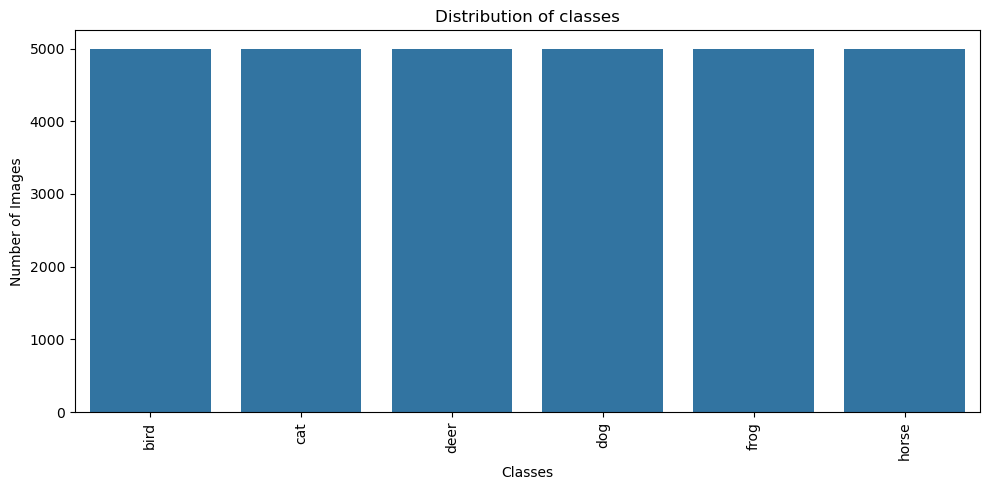

In [20]:
class_count =  get_class_summary(y_train_filtered)
plot_distribution(class_count)

# Examples

## Known classes

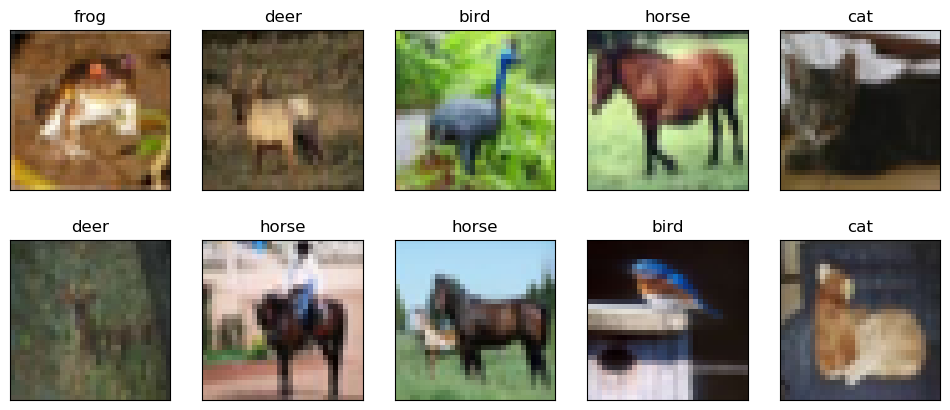

In [21]:
show_image_grid(X_train_filtered[:10], y_train_filtered[:10], 2, 5, (12,5))

## Unknown classes

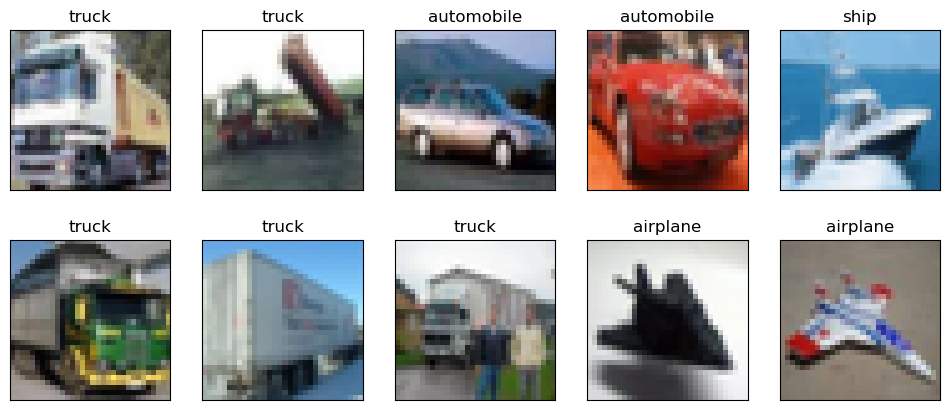

In [22]:
show_image_grid(X_train_unknown[:10], y_train_unknown[:10], 2, 5, (12,5))

# Preprocess images

## One-hot encoding of labels

In [23]:
enc = OneHotEncoder()
y_train_enc=enc.fit_transform(y_train_filtered).toarray().astype(int)
y_test_enc=enc.transform(y_test_filtered).toarray().astype(int)

## Flow generation

In [24]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [25]:
train_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=128,
    shuffle=True,
    seed=SEED,
    subset='training'
)

val_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=128,
    shuffle=True,
    seed=SEED,
    subset='validation'
)

test_flow = test_generator.flow(
    x=X_test_filtered,
    y=y_test_enc,
    batch_size=128,
    shuffle=False
)

# Fit simple CNN for classification

In [26]:
my_model = build_simple_cnn()

### Compile model

In [27]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Fit model

In [28]:
my_history = my_model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
188/188 [==============================] - 19s 96ms/step - loss: 1.5871 - accuracy: 0.3685 - val_loss: 3.0263 - val_accuracy: 0.2022
Epoch 2/50
188/188 [==============================] - 18s 98ms/step - loss: 1.3356 - accuracy: 0.4751 - val_loss: 2.2168 - val_accuracy: 0.2810
Epoch 3/50
188/188 [==============================] - 18s 96ms/step - loss: 1.2278 - accuracy: 0.5275 - val_loss: 1.2843 - val_accuracy: 0.5027
Epoch 4/50
188/188 [==============================] - 18s 97ms/step - loss: 1.1554 - accuracy: 0.5596 - val_loss: 1.0548 - val_accuracy: 0.6002
Epoch 5/50
188/188 [==============================] - 18s 97ms/step - loss: 1.0909 - accuracy: 0.5854 - val_loss: 1.0212 - val_accuracy: 0.6120
Epoch 6/50
188/188 [==============================] - 18s 97ms/step - loss: 1.0416 - accuracy: 0.6054 - val_loss: 1.1116 - val_accuracy: 0.5870
Epoch 7/50
188/188 [==============================] - 18s 97ms/step - loss: 1.0030 - accuracy: 0.6217 - val_loss: 0.9808 - val_accuracy:

### Save weights to skip training in the future

In [29]:
my_model.save_weights('models/my_model_weights_6_class_v2.keras')

### Simply load saved weights

In [30]:
my_model.load_weights('models/my_model_weights_6_class_v2.keras')

### Evaluate model

In [31]:
loss, accuracy = my_model.evaluate(test_flow, verbose=1)
print(f"Test accuracy: {accuracy*100:.2f}%, test loss: {loss:.4f}")

47/47 [==============================] - 1s 20ms/step - loss: 0.5927 - accuracy: 0.7960
Test accuracy: 79.60%, test loss: 0.5927


### Get intermediate models

In [32]:
# Model to get CNN output (flattened)
cnn_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('cnn_output').output)

# Model to get first Dense output
dense_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('dense_1').output)

# Model to get logits (before softmax)
logits_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('logits').output)

# Extract features using different layers of the CNN classifier

## Construct datasets for outlier search

### 10% contamination in training set: 4500 known, 500 unknown elements

In [33]:
# Step 1: Get 500 from unknown
X_unknown_subset, _, y_unknown_subset, _ = train_test_split(
    X_train_unknown, y_train_unknown, test_size=(len(X_train_unknown) - 500), random_state=SEED, shuffle=True
)

# Step 2: Get 4500 from filtered
X_filtered_subset, _, y_filtered_subset, _ = train_test_split(
    X_train_filtered, y_train_filtered, test_size=(len(X_train_filtered) - 4500), random_state=SEED, shuffle=True
)

# Step 3: Combine
X_combined = np.concatenate([X_filtered_subset, X_unknown_subset], axis=0)
y_combined = np.concatenate([y_filtered_subset, y_unknown_subset], axis=0)

In [34]:
X_combined.shape, y_combined.shape

((5000, 32, 32, 3), (5000, 1))

In [35]:
subset_train_flow = train_generator.flow(X_combined, y_combined, batch_size=256, shuffle=True, seed=SEED)

### Generate balanaced test data out of 2500 known and 2500 unknown samples

In [157]:
# Step 1: Get 2500 from unknown
X_unknown_subset_test, _, y_unknown_subset_test, _ = train_test_split(
    X_train_unknown, y_train_unknown, test_size=(len(X_train_unknown) - 2500), random_state=SEED, shuffle=True
)

# Step 2: Get 2500 from filtered
X_filtered_subset_test, _, y_filtered_subset_test, _ = train_test_split(
    X_train_filtered, y_train_filtered, test_size=(len(X_train_filtered) - 2500), random_state=SEED, shuffle=True
)

# Step 3: Combine
X_combined_test = np.concatenate([X_filtered_subset_test, X_unknown_subset_test], axis=0)
y_combined_test = np.concatenate([y_filtered_subset_test, y_unknown_subset_test], axis=0)

# Step 4: Create "known vs unknown" labels
is_known = np.concatenate([
    np.ones(len(X_filtered_subset_test)),   # known = 1
    -1 * np.ones(len(X_unknown_subset_test))  # unknown = -1
])

In [158]:
X_combined_test.shape, y_combined_test.shape

((5000, 32, 32, 3), (5000, 1))

In [159]:
subset_test_flow = train_generator.flow(X_combined_test, y_combined_test, batch_size=256, shuffle=False, seed=SEED)

## CNN as feature extractor

In [39]:
train_features_cnn = cnn_output_model.predict(subset_train_flow, verbose=1)
test_features_cnn =  cnn_output_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 3s 133ms/step


In [40]:
train_features_cnn.shape

(5000, 1024)

### Reduce feature number

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
train_reduced_cnn = pca.fit_transform(train_features_cnn)
test_reduced_cnn = pca.fit_transform(test_features_cnn)

In [42]:
train_reduced_cnn.shape

(5000, 256)

### Fit isolation forest

In [43]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_cnn, 
    test_features = test_features_cnn
)
outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 47.78%
               precision    recall  f1-score   support

Unknown (OOD)       0.36      0.06      0.10      2500
        Known       0.49      0.90      0.63      2500

     accuracy                           0.48      5000
    macro avg       0.42      0.48      0.36      5000
 weighted avg       0.42      0.48      0.36      5000



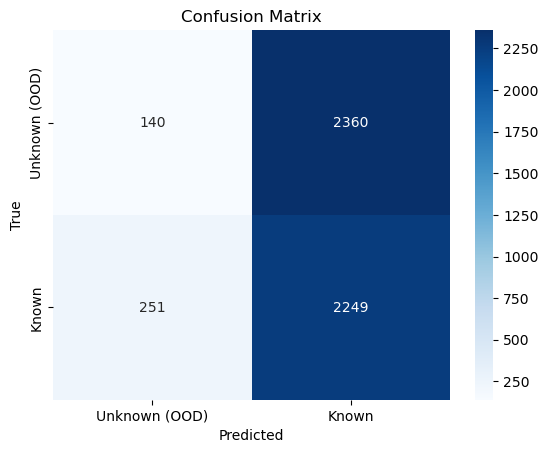

In [44]:
print_evaluation_report(is_known, predictions)

In [45]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.029100  -0.065626   0.073803   0.021823        bird
1      1    0.031062  -0.034751   0.083246   0.019186         cat
2      2    0.029680  -0.042014   0.079106   0.020107        deer
3      3    0.030487  -0.038816   0.082117   0.020265         dog
4      4    0.029691  -0.049360   0.080683   0.020100        frog
5      5    0.029475  -0.044829   0.075380   0.020191       horse
6      6    0.044164  -0.008698   0.072388   0.015939        ship
7      7    0.025565  -0.021213   0.065970   0.016811       truck
8      8    0.024135  -0.025996   0.059386   0.019281  automobile
9      9    0.036455  -0.010595   0.070742   0.015952    airplane


In [46]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     19        bird
1      1     22         cat
2      2     21        deer
3      3     33         dog
4      4     34        frog
5      5    122       horse
6      6     10        ship
7      7     46       truck
8      8     54  automobile
9      9     30    airplane


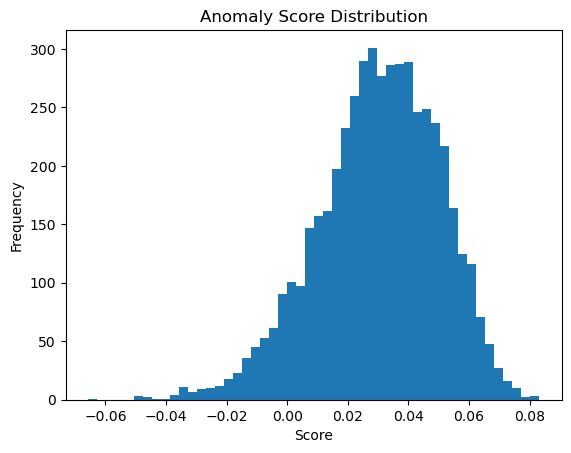

In [47]:
show_anomaly_score_plot(anomaly_scores)

## Dense layer features

In [48]:
train_features_dense = dense_output_model.predict(subset_train_flow, verbose=1)
test_features_dense =  dense_output_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 3s 127ms/step


In [49]:
train_features_dense.shape

(5000, 128)

In [81]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_dense, 
    test_features = test_features_dense
)

outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 45.04%
               precision    recall  f1-score   support

Unknown (OOD)       0.02      0.00      0.00      2500
        Known       0.47      0.90      0.62      2500

     accuracy                           0.45      5000
    macro avg       0.25      0.45      0.31      5000
 weighted avg       0.25      0.45      0.31      5000



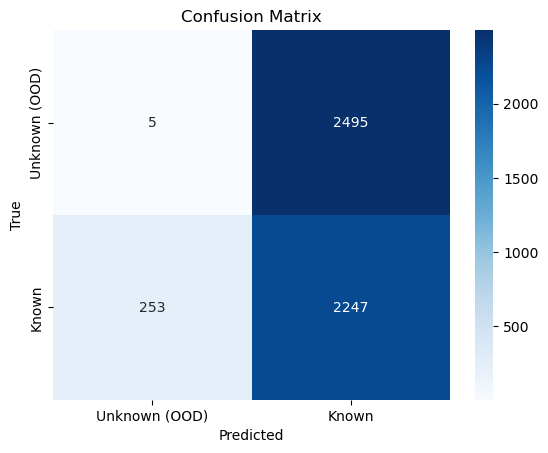

In [82]:
print_evaluation_report(is_known, predictions)

In [71]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.074110  -0.117020   0.131647   0.040760        bird
1      1    0.075633  -0.109879   0.129964   0.040413         cat
2      2    0.075495  -0.111125   0.131997   0.040675        deer
3      3    0.075168  -0.099746   0.132835   0.038456         dog
4      4    0.074430  -0.124272   0.130054   0.040568        frog
5      5    0.074874  -0.121165   0.127863   0.040262       horse
6      6    0.091525  -0.003614   0.129163   0.020762        ship
7      7    0.105323   0.044124   0.128484   0.015735       truck
8      8    0.097226  -0.027082   0.127939   0.025740  automobile
9      9    0.083685   0.000729   0.128641   0.025694    airplane


In [78]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0    155        bird
1      1    185         cat
2      2    196        deer
3      3    188         dog
4      4    154        frog
5      5    133       horse
6      6    288        ship
7      7    159       truck
8      8    187  automobile
9      9    317    airplane


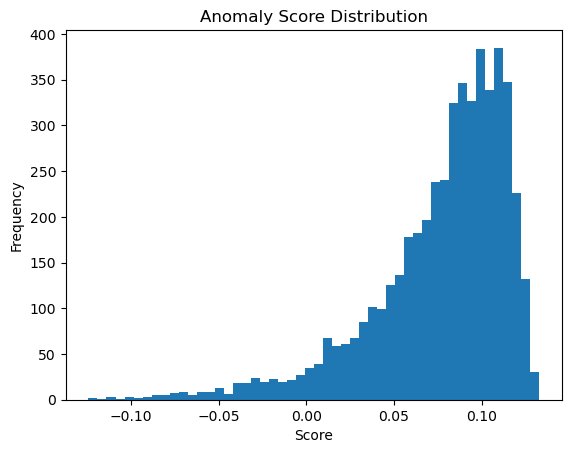

In [54]:
show_anomaly_score_plot(anomaly_scores)

## Logits

In [160]:
train_features_logits = logits_model.predict(subset_train_flow, verbose=1)
test_features_logits =  logits_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 2s 107ms/step


In [161]:
train_features_logits.shape

(5000, 6)

In [217]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_logits, 
    test_features = test_features_logits
)

outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 44.34%
               precision    recall  f1-score   support

Unknown (OOD)       0.01      0.00      0.00      2500
        Known       0.47      0.89      0.61      2500

     accuracy                           0.44      5000
    macro avg       0.24      0.44      0.31      5000
 weighted avg       0.24      0.44      0.31      5000



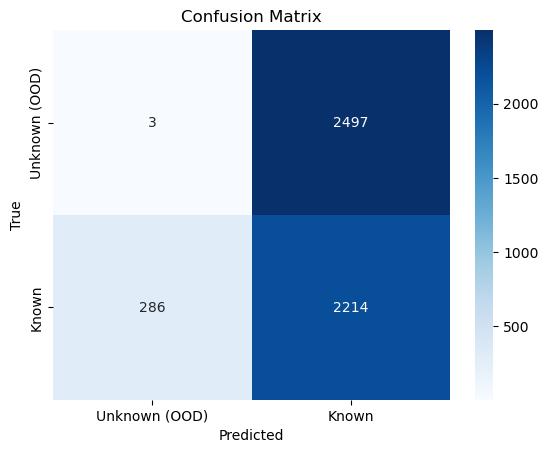

In [218]:
print_evaluation_report(is_known, predictions)

In [219]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.098038  -0.113407   0.159897   0.052888        bird
1      1    0.098215  -0.099380   0.160350   0.052075         cat
2      2    0.098410  -0.127698   0.160214   0.051498        deer
3      3    0.100962  -0.136700   0.162259   0.050623         dog
4      4    0.100081  -0.148780   0.158664   0.050932        frog
5      5    0.098582  -0.121447   0.160996   0.052190       horse
6      6    0.127070   0.044320   0.159801   0.023055        ship
7      7    0.130683   0.086984   0.158054   0.016404       truck
8      8    0.127508  -0.010661   0.159174   0.027222  automobile
9      9    0.110351   0.017176   0.161727   0.036087    airplane


In [220]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     27        bird
1      1     25         cat
2      2     24        deer
3      3     49         dog
4      4     69        frog
5      5     92       horse
6      8      2  automobile
7      9      1    airplane


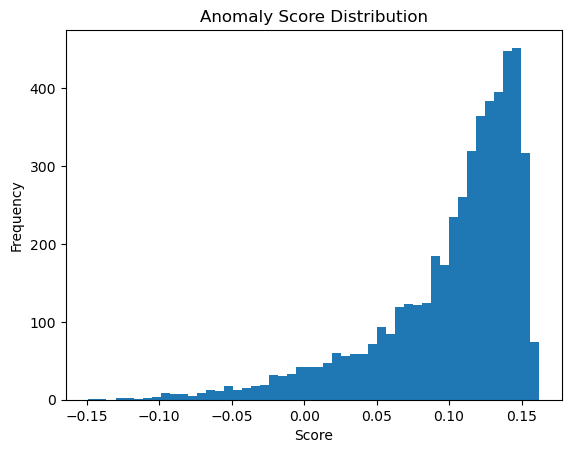

In [221]:
show_anomaly_score_plot(anomaly_scores)

### Try a different thresholding method

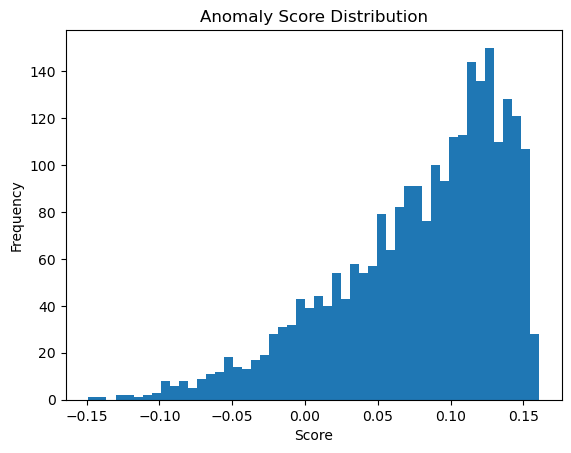

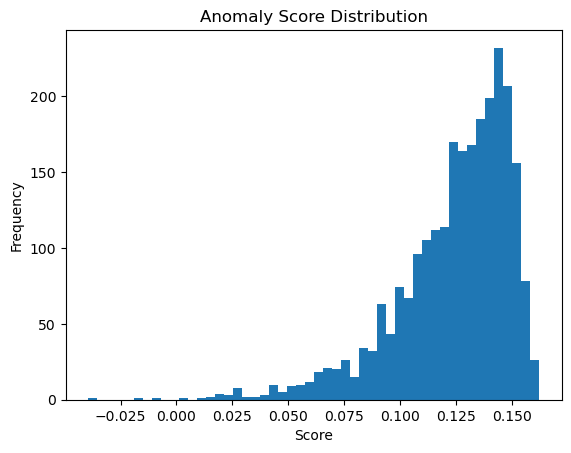

In [227]:
# Get ID and OOD masks
id_mask = is_known == 1
ood_mask = is_known == -1

# Split the anomaly scores
id_scores = anomaly_scores[id_mask]
ood_scores = anomaly_scores[ood_mask]

show_anomaly_score_plot(id_scores)
show_anomaly_score_plot(ood_scores)

In [228]:
# Function to print stats
def print_stats(name, scores):
    print(f"\n{name} statistics:")
    print(f"  Count      : {len(scores)}")
    print(f"  Mean       : {np.mean(scores):.5f}")
    print(f"  Std Dev    : {np.std(scores):.5f}")
    print(f"  Min        : {np.min(scores):.5f}")
    print(f"  Max        : {np.max(scores):.5f}")
    print(f"  Q1         : {np.percentile(scores, 25):.5f}")
    print(f"  Median (Q2): {np.median(scores):.5f}")
    print(f"  Q3         : {np.percentile(scores, 75):.5f}")

# Print stats
print_stats("All", anomaly_scores)
print_stats("ID", id_scores)
print_stats("OOD", ood_scores)


All statistics:
  Count      : 5000
  Mean       : 0.10147
  Std Dev    : 0.05036
  Min        : -0.14878
  Max        : 0.16226
  Q1         : 0.08028
  Median (Q2): 0.11748
  Q3         : 0.13803

ID statistics:
  Count      : 2500
  Mean       : 0.07880
  Std Dev    : 0.05803
  Min        : -0.14878
  Max        : 0.16100
  Q1         : 0.04426
  Median (Q2): 0.09240
  Q3         : 0.12449

OOD statistics:
  Count      : 2500
  Mean       : 0.12413
  Std Dev    : 0.02605
  Min        : -0.03935
  Max        : 0.16226
  Q1         : 0.11177
  Median (Q2): 0.13003
  Q3         : 0.14328


In [229]:
mean_score = np.mean(anomaly_scores)
std_score = np.std(anomaly_scores)
best_acc = 0
best_val = 0
for value in np.arange(0, 1.0001, 0.005):
    outlier_indices = np.where(
        (anomaly_scores >= mean_score + value*std_score)
    )[0]
    # Create a default array of 1s
    predictions = np.ones(len(anomaly_scores), dtype=int)
    
    # Set to -1 where the anomaly score is outside the range
    predictions[outlier_indices] = -1
    
    accuracy = accuracy_score(is_known, predictions)

    if accuracy > best_acc:
        best_val = value
        best_acc = accuracy

outlier_indices = np.where(
    (anomaly_scores >= mean_score + best_val*std_score)
)[0]
# Create a default array of 1s
predictions = np.ones(len(anomaly_scores), dtype=int)

# Set to -1 where the anomaly score is outside the range
predictions[outlier_indices] = -1

Outlier Detection Accuracy: 69.82%
               precision    recall  f1-score   support

Unknown (OOD)       0.66      0.81      0.73      2500
        Known       0.75      0.59      0.66      2500

     accuracy                           0.70      5000
    macro avg       0.71      0.70      0.69      5000
 weighted avg       0.71      0.70      0.69      5000



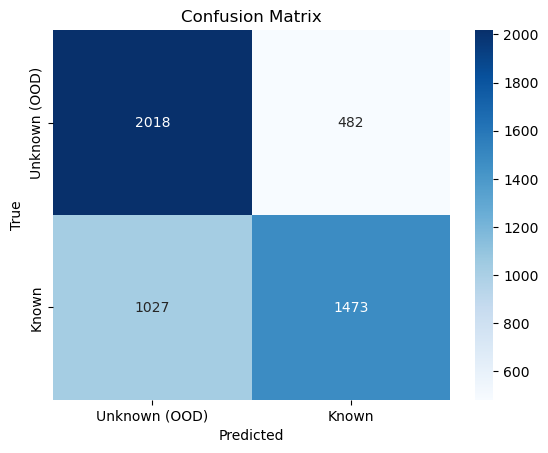

In [230]:
print_evaluation_report(is_known, predictions)

## Model output

In [62]:
train_features = my_model.predict(subset_train_flow, verbose=1)
test_features =  my_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 3s 141ms/step


In [63]:
train_features.shape

(5000, 6)

In [179]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features, 
    test_features = test_features
)
outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 56.12%
               precision    recall  f1-score   support

Unknown (OOD)       0.69      0.22      0.33      2500
        Known       0.54      0.90      0.67      2500

     accuracy                           0.56      5000
    macro avg       0.61      0.56      0.50      5000
 weighted avg       0.61      0.56      0.50      5000



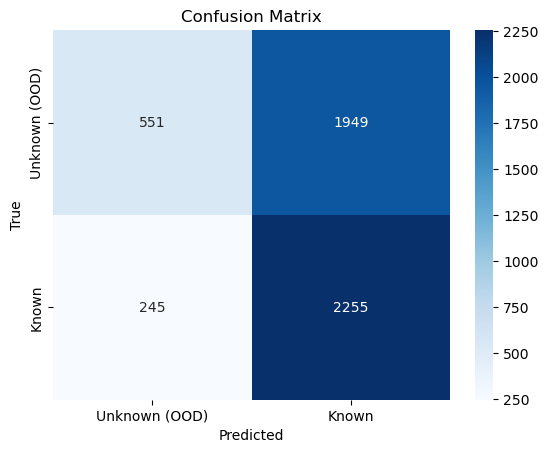

In [180]:
print_evaluation_report(is_known, predictions)

In [181]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.034586  -0.040329   0.109416   0.034602        bird
1      1    0.033192  -0.036482   0.109416   0.033948         cat
2      2    0.034986  -0.033267   0.109416   0.033642        deer
3      3    0.032510  -0.036753   0.109416   0.033248         dog
4      4    0.033204  -0.054170   0.109416   0.034466        frog
5      5    0.032380  -0.030213   0.109416   0.034224       horse
6      6    0.020479  -0.021406   0.094654   0.017644        ship
7      7    0.007398  -0.023552   0.072946   0.019196       truck
8      8    0.010473  -0.027344   0.092297   0.022286  automobile
9      9    0.031877  -0.026233   0.093156   0.026719    airplane


In [182]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     20        bird
1      1     35         cat
2      2     61        deer
3      3     61         dog
4      4     30        frog
5      5     38       horse
6      6     78        ship
7      7    218       truck
8      8    210  automobile
9      9     45    airplane


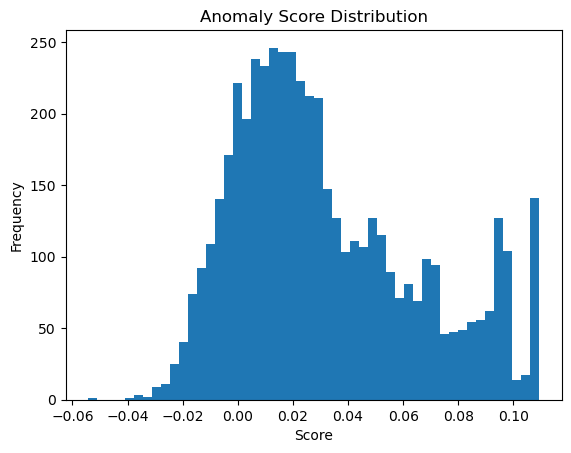

In [183]:
show_anomaly_score_plot(anomaly_scores)